In [42]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

# Convert PyTorch model to ONNX

In [43]:
def one_param(m):
    "get model first parameter"
    return next(iter(m.parameters()))

class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            #nn.InstanceNorm2d(mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
            #nn.InstanceNorm2d(out_channels),
        )

    def forward(self, x):
        if self.residual:

            out = F.gelu(x + self.double_conv(x))

            return out
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)

        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet_student_v2(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, remove_deep_conv=False):
        super().__init__()
        self.time_dim = time_dim
        self.remove_deep_conv = remove_deep_conv
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256)

        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256)


        if remove_deep_conv:
            self.bot1 = DoubleConv(256, 256)
            self.bot3 = DoubleConv(256, 256)
        else:
            self.bot1 = DoubleConv(256, 256)
            #self.bot2 = DoubleConv(512, 256)
            self.bot3 = DoubleConv(256,128)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128)

        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64)

        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device='cpu').float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def unet_forward(self, x, t):
        #print("Input size:",x.size())
        x1 = self.inc(x)
        #print("Input size after inc1 :",x1.size())
        x2 = self.down1(x1, t)
        #print("Input size after down1 :",x2.size())
        x2 = self.sa1(x2)
        #print("Input size after sa1 :",x2.size())
        x3 = self.down2(x2, t)
        #print("Input size after down2 :",x3.size())
        x3 = self.sa2(x3)
        #print("Input size after sa2 :",x3.size())

        x4 = self.bot1(x3)
        #print("Input size after bottle1 :",x4.size())

        #x4 = self.bot2(x4)
        #print("Input size after bottle2 :",x4.size())

        x4 = self.bot3(x4)
        #print("Input size after bottle3 :",x4.size())


        x = self.up2(x4, x2, t)
        #print("Input size after up2 :",x.size())
        x = self.sa5(x)
        #print("Input size after sa5 :",x.size())
        x = self.up3(x, x1, t)
        #print("Input size after up3 :",x.size())
        x = self.sa6(x)
        #print("Input size after sa6 :",x.size())
        output = self.outc(x)
        #print("Ouput size :",output.size())
        return output

    def forward(self, x, t):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)
        return self.unet_forward(x, t)



In [44]:
class UNet_conditional_student_v2(UNet_student_v2):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None, **kwargs):
        super().__init__(c_in, c_out, time_dim, **kwargs)
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def forward(self, x, t, y=None):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y.long())

        return self.unet_forward(x, t)

In [45]:
model = UNet_conditional_student_v2(num_classes=10)
model.load_state_dict(torch.load('/content/student_v2.pt', map_location='cpu'))
model = model.eval()

In [46]:
inp = torch.randn((1,3,64,64))
t = torch.Tensor(torch.ones(1))
y = torch.Tensor([6] * 1)

onnx_model_path = '/content/converted_model.onnx'

In [47]:
out = model(inp,t,y)

In [48]:
#Install ONNX
!pip install onnx
!pip install onnxruntime
!pip install tensorflow_addons

In [49]:
#Export from torch to ONNX
torch.onnx.export(
    model,                  # PyTorch Model
    (inp,t,y),                    # Input tensor
    onnx_model_path,        # Output file (eg. 'output_model.onnx')
    opset_version=14,       # Operator support version
    input_names=['input'],   # Input tensor name (arbitary)
    output_names=['output'] # Output tensor name (arbitary)
)

In [ ]:
%%bash
git clone https://github.com/onnx/onnx-tensorflow.git && cd onnx-tensorflow && pip install -e .

In [53]:
import sys
sys.path.append("./onnx-tensorflow")

In [54]:
import onnx
onnx_model = onnx.load(onnx_model_path)

In [55]:
%cd '/content'

/content


In [56]:
import onnx
from onnx import helper

onnx_model = onnx.load('/content/converted_model.onnx')

# Define a mapping from old names to new names
name_map = {"input.1": "input_1","onnx::Unsqueeze_1":"onnx__Unsqueeze_1","onnx::Cast_2":"onnx__Cast_2"}

# Initialize a list to hold the new inputs
new_inputs = []

# Iterate over the inputs and change their names if needed
for inp in onnx_model.graph.input:
    if inp.name in name_map:
        # Create a new ValueInfoProto with the new name
        new_inp = helper.make_tensor_value_info(name_map[inp.name],
                                                inp.type.tensor_type.elem_type,
                                                [dim.dim_value for dim in inp.type.tensor_type.shape.dim])
        new_inputs.append(new_inp)
    else:
        new_inputs.append(inp)

# Clear the old inputs and add the new ones
onnx_model.graph.ClearField("input")
onnx_model.graph.input.extend(new_inputs)

# Go through all nodes in the model and replace the old input name with the new one
for node in onnx_model.graph.node:
    for i, input_name in enumerate(node.input):
        if input_name in name_map:
            node.input[i] = name_map[input_name]

# Save the renamed ONNX model
onnx.save(onnx_model, 'model_new.onnx')

In [19]:
onnx_model_path = '/content/model_new.onnx'
onnx_model = onnx.load(onnx_model_path)

from onnx_tf.backend import prepare

tf_model_path = 'tf_folder'
tf_rep = prepare(onnx_model)
tf_rep.export_graph(tf_model_path)

Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.
INFO:absl:Function `__call__` contains input name(s) onnx__Cast_2, onnx__Unsqueeze_1, params, x, b, y with unsupported characters which will be renamed to onnx__cast_2, onnx__unsqueeze_1, onnx_tf_prefix__label_emb_gather_params, transpose_58_x, onnx_tf_prefix__sa6_ff_self_ff_self_3_matmul_b, onnx_tf_prefix__bot1_double_conv_double_conv_4_add_y in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:absl:Writing fingerprint to v2_tf/fingerprint.pb


In [57]:
import tensorflow as tf

In [58]:
print(tf.__version__)

2.15.0


In [59]:
input_nodes = tf_rep.inputs
output_nodes = tf_rep.outputs

In [60]:
print("The names of the input nodes are: {}".format(input_nodes))
print("The names of the output nodes are: {}".format(output_nodes))

The names of the input nodes are: ['input', 'onnx__Unsqueeze_1', 'onnx__Cast_2']
The names of the output nodes are: ['output']


In [ ]:
pb_path = '/content/tf_folder/saved_model.pb'

In [71]:
def representative_dataset():
    inp = tf.random.uniform((100,3,64,64),dtype=tf.dtypes.float32)
    t = tf.ones((100,1),dtype=tf.float32)
    y = tf.ones((100,1),dtype=tf.float32)
    images = [inp,t,y]

    #for data in tf.data.Dataset.from_tensor_slices((images)).batch(1).take(100):
    yield [tf.dtypes.cast(images, tf.float32)]

In [61]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/'+tf_model_path)

converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

converter.target_spec.supported_types = [tf.int8,tf.float32]
converter.optimizations = [tf.lite.Optimize.DEFAULT]

#converter.representative_dataset = representative_dataset

converter.inference_input_type  = tf.float32
converter.inference_output_type = tf.float32

tflite_model = converter.convert()
tflite_mpath = 'tflite_model.tflite'

# Save the model
with open(tflite_mpath, 'wb') as f:
    f.write(tflite_model)

# FLOPS calc

In [ ]:
!pip install fvcore

In [ ]:
from fvcore.nn import FlopCountAnalysis

flops = FlopCountAnalysis(model, (inp,t,y))
flops.total()

#Inference

In [62]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="/content/tflite_model.tflite")
interpreter.allocate_tensors()

In [63]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data
input_shape0 = input_details[0]['shape']
input_shape1 = input_details[1]['shape']
input_shape2 = input_details[2]['shape']
#print(input_shape1)

input_data0 = np.array(np.random.random_sample(input_shape0), dtype=np.float32)
input_data1 = np.array(np.random.random_sample(input_shape1), dtype=np.float32)
input_data2 = np.array(np.random.random_sample(input_shape2), dtype=np.float32)

interpreter.set_tensor(input_details[0]['index'], input_data0)
interpreter.set_tensor(input_details[1]['index'], input_data1)
interpreter.set_tensor(input_details[2]['index'], input_data2)


In [64]:
interpreter.invoke()

In [65]:
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data.shape)

(1, 3, 64, 64)


In [66]:
import matplotlib.pyplot as plt

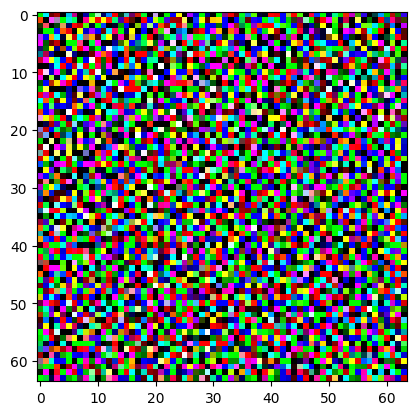

In [67]:
plt.imshow(output_data[0].transpose(1,2,0))
plt.show()